In [22]:
!pip install transformers datasets scikit-learn seaborn -q

import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split
from transformers import AutoImageProcessor, AutoModelForImageClassification, TrainingArguments, Trainer
import torch.nn as nn
import torch.optim as optim
import numpy as np
import os
import time
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import seaborn as sn
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import psutil

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Set device (Gunakan GPU jika tersedia)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Using device: cuda


In [4]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Download dan unzip dataset
!kaggle datasets download -d rizkyyk/dataset-food-classification -p /content/data --unzip
print("Dataset downloaded and unzipped.")

Dataset URL: https://www.kaggle.com/datasets/rizkyyk/dataset-food-classification
License(s): MIT
 97% 1.05G/1.09G [00:08<00:00, 73.9MB/s]
100% 1.09G/1.09G [00:08<00:00, 140MB/s] 
Dataset downloaded and unzipped.


In [5]:
DATASET_ROOT = "/content/data/dataset_gambar"

TRAIN_PATH = os.path.join(DATASET_ROOT, "train")
VAL_PATH = os.path.join(DATASET_ROOT, "valid")
TEST_PATH = os.path.join(DATASET_ROOT, "test")

SAVE_PATH = "/content/drive/My Drive/ViT_Project"
os.makedirs(SAVE_PATH, exist_ok=True)
BEST_MODEL_PATH = os.path.join(SAVE_PATH, "vit_murni_best.pth")

# Definisi Model ID dan Processor
MODEL_ID = "google/vit-base-patch16-224"
image_processor = AutoImageProcessor.from_pretrained(MODEL_ID)

# Ekstrak mean dan std dari processor untuk normalisasi
image_mean = image_processor.image_mean
image_std = image_processor.image_std
size = image_processor.size["height"] # Harusnya 224

Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.


In [6]:
# Augmentasi Data
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(size, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=image_mean, std=image_std),
])

val_test_transforms = transforms.Compose([
    transforms.Resize(size + 32), # 256
    transforms.CenterCrop(size),  # 224
    transforms.ToTensor(),
    transforms.Normalize(mean=image_mean, std=image_std),
])

# Buat Datasets
# Terapkan transform yang benar ke folder yang benar
train_dataset = ImageFolder(TRAIN_PATH, transform=train_transforms)
val_dataset = ImageFolder(VAL_PATH, transform=val_test_transforms)
test_dataset = ImageFolder(TEST_PATH, transform=val_test_transforms)


In [7]:
# Ekstrak mean dan std dari processor untuk normalisasi
image_mean = image_processor.image_mean
image_std = image_processor.image_std
size = image_processor.size["height"] # Harusnya 224

# Dapatkan nama kelas dari train_dataset
class_names = train_dataset.classes
num_labels = len(class_names)
print(f"Kelas ditemukan ({num_labels}): {class_names}")
print(f"Ukuran Data: {len(train_dataset)} train, {len(val_dataset)} val, {len(test_dataset)} test")

# Buat DataLoaders
BATCH_SIZE = 32

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

Kelas ditemukan (13): ['Ayam Goreng', 'Burger', 'French Fries', 'Gado-Gado', 'Ikan Goreng', 'Mie Goreng', 'Nasi Goreng', 'Nasi Padang', 'Pizza', 'Rawon', 'Rendang', 'Sate', 'Soto']
Ukuran Data: 5193 train, 650 val, 648 test


In [8]:
print(f"Memuat model pretrained: {MODEL_ID}")
model = AutoModelForImageClassification.from_pretrained(
    MODEL_ID,
    num_labels=num_labels,
    ignore_mismatched_sizes=True # Ganti head klasifikasi
).to(device)

for param in model.parameters():
    param.requires_grad = True
print("Semua parameter model telah di-unfreeze (requires_grad=True).")

Memuat model pretrained: google/vit-base-patch16-224


model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([13]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([13, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Semua parameter model telah di-unfreeze (requires_grad=True).


In [9]:
print(model)

ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=768, out_features=3072, bias=True)
            (intermed

In [10]:
NUM_EPOCHS = 5
LEARNING_RATE = 5e-5
criterion = nn.CrossEntropyLoss() # Gunakan Loss Function CrossEntropyLoss
optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE) # Gunakan Optimizer AdamW
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer,
    T_max=NUM_EPOCHS,
    eta_min=1e-6  # Nilai LR minimum yang akan dicapai
)
# Variabel untuk menyimpan model terbaik
best_val_accuracy = 0.0

# History untuk plotting
history = {
    'train_loss': [], 'train_acc': [],
    'val_loss': [], 'val_acc': []
}

In [11]:
print("Memulai pelatihan...")

# --- Loop Pelatihan ---
# Loop untuk setiap siklus penuh data (epoch)
for epoch in range(NUM_EPOCHS):

    # --- Training ---
    model.train() # Set model ke mode training (aktifkan dropout, dll)
    # Reset statistik untuk epoch ini
    running_train_loss = 0.0
    correct_train = 0
    total_train = 0

    # Buat progress bar untuk loop training
    train_pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS} [Train]")
    # Loop untuk setiap batch (sekelompok data)
    for inputs, labels in train_pbar:
        # Pindahkan data ke GPU
        inputs, labels = inputs.to(device), labels.to(device)

        # (Langkah 1) Bersihkan gradien dari batch sebelumnya
        optimizer.zero_grad()

        # (Langkah 2) Dapatkan prediksi model (Forward Pass)
        outputs = model(inputs)
        # (Langkah 3) Hitung seberapa salah prediksi (Loss)
        loss = criterion(outputs.logits, labels)

        # (Langkah 4) Hitung gradien (turunan) dari loss (Backpropagation)
        loss.backward()
        # (Langkah 5) Update bobot model berdasarkan gradien
        optimizer.step()

        # Kumpulkan statistik loss dan akurasi
        running_train_loss += loss.item() # .item() ambil angka dari tensor
        _, predicted = torch.max(outputs.logits, 1) # Ambil kelas prediksi
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

        # Update tampilan loss di progress bar
        train_pbar.set_postfix({'loss': running_train_loss / (train_pbar.n + 1)})

    # Hitung rata-rata loss & akurasi untuk epoch training
    train_loss = running_train_loss / len(train_loader)
    train_acc = 100 * correct_train / total_train
    # Simpan hasil untuk digambar (plotting)
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)

    # --- Validation ---
    model.eval() # Set model ke mode evaluasi (matikan dropout, dll)
    # Reset statistik untuk validasi
    running_val_loss = 0.0
    correct_val = 0
    total_val = 0

    # Buat progress bar untuk loop validasi
    val_pbar = tqdm(val_loader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS} [Val]")

    # Matikan perhitungan gradien (hemat memori & lebih cepat)
    with torch.no_grad():
        for inputs, labels in val_pbar:
            inputs, labels = inputs.to(device), labels.to(device)

            # Dapatkan prediksi (Forward pass)
            outputs = model(inputs)
            # Hitung loss
            loss = criterion(outputs.logits, labels)

            # Kumpulkan statistik loss dan akurasi
            running_val_loss += loss.item()
            _, predicted = torch.max(outputs.logits, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

            val_pbar.set_postfix({'val_loss': running_val_loss / (val_pbar.n + 1)})

    # Hitung rata-rata loss & akurasi untuk validasi
    val_loss = running_val_loss / len(val_loader)
    val_acc = 100 * correct_val / total_val
    # Simpan hasil untuk plotting
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)

    # Cetak ringkasan epoch
    print(f"Epoch {epoch+1}/{NUM_EPOCHS} - "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}% - "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

    # Update learning rate (jika pakai scheduler)
    scheduler.step()
    print(f"Current LR: {scheduler.get_last_lr()[0]}")

    # --- Checkpointing (Simpan Model) ---
    # Cek apakah akurasi validasi saat ini lebih baik dari yang terbaik
    if val_acc > best_val_accuracy:
        best_val_accuracy = val_acc # Update skor terbaik
        # Simpan bobot (parameters) model ke file
        torch.save(model.state_dict(), BEST_MODEL_PATH)
        print(f"Model terbaik disimpan ke {BEST_MODEL_PATH} (Val Acc: {val_acc:.2f}%)")

print("Pelatihan selesai.")

Memulai pelatihan...


Epoch 1/5 [Train]:   0%|          | 0/163 [00:00<?, ?it/s]

Epoch 1/5 [Val]:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch 1/5 - Train Loss: 0.4912, Train Acc: 88.54% - Val Loss: 0.1357, Val Acc: 96.62%
Current LR: 4.532091636218621e-05
Model terbaik disimpan ke /content/drive/My Drive/ViT_Project/vit_murni_best.pth (Val Acc: 96.62%)


Epoch 2/5 [Train]:   0%|          | 0/163 [00:00<?, ?it/s]

Epoch 2/5 [Val]:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch 2/5 - Train Loss: 0.1074, Train Acc: 97.46% - Val Loss: 0.1351, Val Acc: 95.38%
Current LR: 3.307091636218621e-05


Epoch 3/5 [Train]:   0%|          | 0/163 [00:00<?, ?it/s]

Epoch 3/5 [Val]:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch 3/5 - Train Loss: 0.0521, Train Acc: 98.81% - Val Loss: 0.0809, Val Acc: 97.69%
Current LR: 1.792908363781379e-05
Model terbaik disimpan ke /content/drive/My Drive/ViT_Project/vit_murni_best.pth (Val Acc: 97.69%)


Epoch 4/5 [Train]:   0%|          | 0/163 [00:00<?, ?it/s]

Epoch 4/5 [Val]:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch 4/5 - Train Loss: 0.0238, Train Acc: 99.54% - Val Loss: 0.0758, Val Acc: 98.00%
Current LR: 5.67908363781379e-06
Model terbaik disimpan ke /content/drive/My Drive/ViT_Project/vit_murni_best.pth (Val Acc: 98.00%)


Epoch 5/5 [Train]:   0%|          | 0/163 [00:00<?, ?it/s]

Epoch 5/5 [Val]:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch 5/5 - Train Loss: 0.0172, Train Acc: 99.65% - Val Loss: 0.0703, Val Acc: 98.31%
Current LR: 1e-06
Model terbaik disimpan ke /content/drive/My Drive/ViT_Project/vit_murni_best.pth (Val Acc: 98.31%)
Pelatihan selesai.


In [12]:
model.load_state_dict(torch.load(BEST_MODEL_PATH))
model.to(device)
model.eval()

ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=768, out_features=3072, bias=True)
            (intermed

In [23]:
print("--- Spesifikasi Hardware ---")

# Cek GPU
if torch.cuda.is_available():
    gpu_name = torch.cuda.get_device_name(0)
    gpu_vram = torch.cuda.get_device_properties(0).total_memory / (1024**3) # GB
    print(f"Device     : GPU ({gpu_name})")
    print(f"VRAM       : {gpu_vram:.2f} GB")
    print(f"CUDA Cap   : {torch.cuda.get_device_capability(0)}")
else:
    print("Device     : CPU (GPU tidak terdeteksi)")

print(f"CPU Cores  : {os.cpu_count()} Cores")

# Cek RAM System
ram_gb = psutil.virtual_memory().total / (1024**3)
print(f"System RAM : {ram_gb:.2f} GB")

print("\n--- Jumlah Parameter ---")
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
non_trainable_params = total_params - trainable_params

# Ukuran model dalam MB
torch.save(model.state_dict(), "temp_model_size.pth")
model_size_mb = os.path.getsize("temp_model_size.pth") / (1024 * 1024)
os.remove("temp_model_size.pth")

print(f"Total parameter: {total_params:,}")
print(f"Parameter dapat dilatih: {trainable_params:,}")
print(f"Parameter tidak dapat dilatih: {non_trainable_params:,}")
print(f"Ukuran model: {model_size_mb:.2f} MB")

--- Spesifikasi Hardware ---
Device     : GPU (Tesla T4)
VRAM       : 14.74 GB
CUDA Cap   : (7, 5)
CPU Cores  : 2 Cores
System RAM : 12.67 GB

--- Jumlah Parameter ---
Total parameter: 85,808,653
Parameter dapat dilatih: 85,808,653
Parameter tidak dapat dilatih: 0
Ukuran model: 327.41 MB


In [14]:
print("\n--- B. Metrik Performa (Test Set) ---")

# Buat list kosong untuk menyimpan label asli dan label prediksi
all_labels = []
all_preds = []

# Matikan perhitungan gradien (kita hanya evaluasi, tidak training)
with torch.no_grad():
    # Loop data dari test_loader (dengan progress bar)
    for inputs, labels in tqdm(test_loader, desc="Mengevaluasi Test Set"):
        # Pindahkan gambar dan label ke GPU
        inputs, labels = inputs.to(device), labels.to(device)

        # Dapatkan prediksi mentah (logits) dari model
        outputs = model(inputs)
        # Ambil indeks (kelas) dengan nilai logit tertinggi sebagai prediksi
        _, predicted = torch.max(outputs.logits, 1)

        # Pindahkan label asli dari GPU ke CPU, ubah ke numpy, dan tambahkan ke list
        all_labels.extend(labels.cpu().numpy())
        # Pindahkan prediksi dari GPU ke CPU, ubah ke numpy, dan tambahkan ke list
        all_preds.extend(predicted.cpu().numpy())


--- B. Metrik Performa (Test Set) ---


Mengevaluasi Test Set:   0%|          | 0/21 [00:00<?, ?it/s]

In [15]:
accuracy = accuracy_score(all_labels, all_preds)
print(f"Akurasi Keseluruhan (Test Set): {accuracy * 100:.2f}%")

Akurasi Keseluruhan (Test Set): 97.38%


In [16]:
print("\nLaporan Klasifikasi (Per Kelas & Rata-rata):")
report = classification_report(all_labels, all_preds, target_names=class_names, digits=4)
print(report)


Laporan Klasifikasi (Per Kelas & Rata-rata):
              precision    recall  f1-score   support

 Ayam Goreng     0.9375    0.9000    0.9184        50
      Burger     1.0000    1.0000    1.0000        50
French Fries     1.0000    1.0000    1.0000        50
   Gado-Gado     0.9608    0.9800    0.9703        50
 Ikan Goreng     0.9423    0.9800    0.9608        50
  Mie Goreng     1.0000    0.9600    0.9796        50
 Nasi Goreng     0.9804    1.0000    0.9901        50
 Nasi Padang     0.9245    0.9800    0.9515        50
       Pizza     1.0000    1.0000    1.0000        50
       Rawon     1.0000    0.9792    0.9895        48
     Rendang     0.9412    0.9600    0.9505        50
        Sate     1.0000    0.9400    0.9691        50
        Soto     0.9800    0.9800    0.9800        50

    accuracy                         0.9738       648
   macro avg     0.9744    0.9738    0.9738       648
weighted avg     0.9743    0.9738    0.9738       648




Confusion Matrix (Visualisasi):


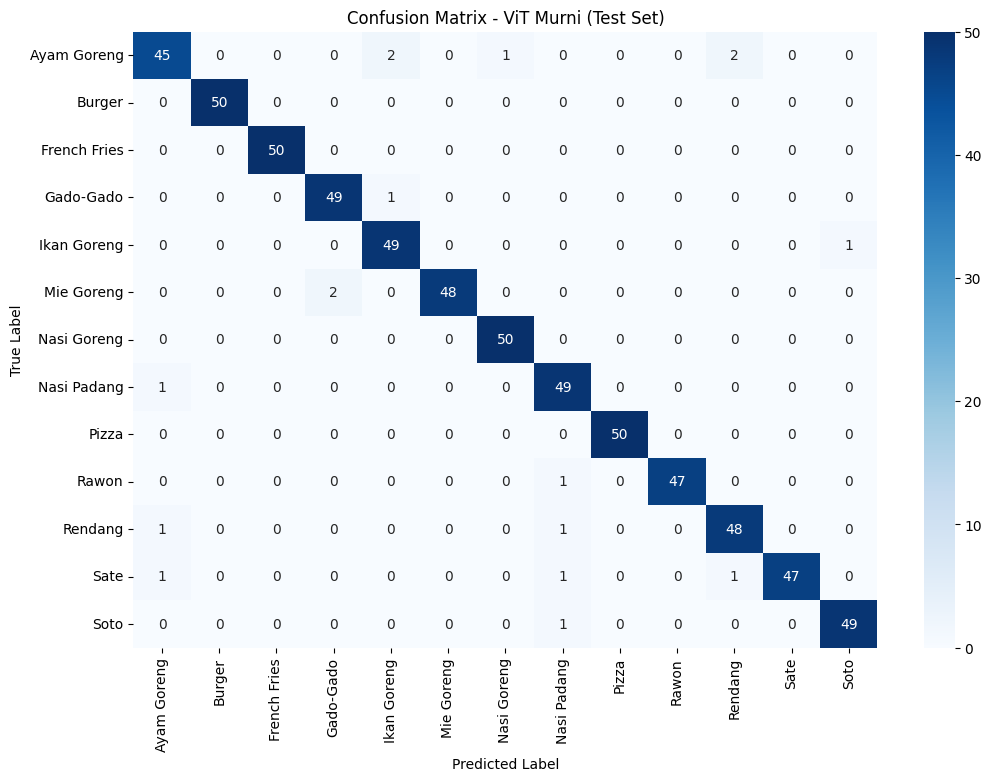

In [17]:
print("\nConfusion Matrix (Visualisasi):")
cm = confusion_matrix(all_labels, all_preds)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
plt.figure(figsize=(12, 8))
sn.heatmap(df_cm, annot=True, fmt='g', cmap='Blues')
plt.title('Confusion Matrix - ViT Murni (Test Set)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


Kurva Pembelajaran (Training & Validation):


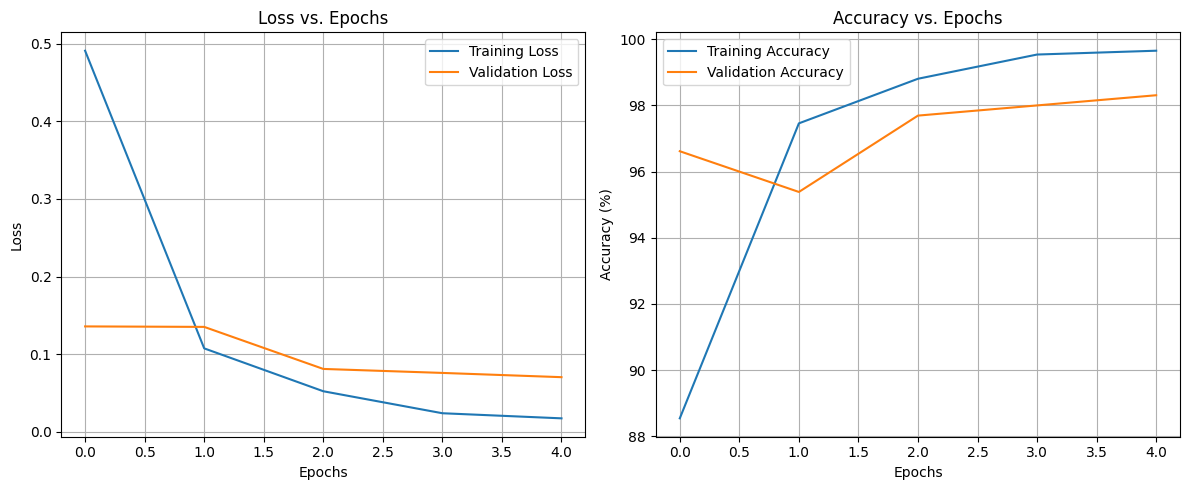

In [18]:
print("\nKurva Pembelajaran (Training & Validation):")
plt.figure(figsize=(12, 5)) # Ukuran 12x5 biasanya lebih baik

# Plot Loss
plt.subplot(1, 2, 1) # Plot 1 (kiri)
plt.plot(history['train_loss'], label='Training Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Loss vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True) # Tambahkan grid agar mudah dibaca

# Plot Accuracy
plt.subplot(1, 2, 2) # Plot 2 (kanan)
plt.plot(history['train_acc'], label='Training Accuracy')
plt.plot(history['val_acc'], label='Validation Accuracy')
plt.title('Accuracy vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True) # Tambahkan grid

plt.tight_layout() # Agar plot tidak tumpang tindih
plt.show()

In [19]:
print("\n--- C. Waktu Inferensi ---")

# Waktu per Gambar (ms)
# Buat loader baru dengan batch_size=1
test_loader_bs1 = DataLoader(test_dataset, batch_size=1, shuffle=False)
iterator_bs1 = iter(test_loader_bs1)

# Persiapan CUDA Events
starter, ender = torch.cuda.Event(enable_timing=True), torch.cuda.Event(enable_timing=True)
timings_ms = []

# Warm-up
print("Melakukan warm-up GPU...")
for _ in range(20):
    _ = model(torch.randn(1, 3, size, size).to(device))

print("Mengukur waktu inferensi per gambar (min 100 gambar)...")
with torch.no_grad():
    for i in range(100):
        try:
            inputs, _ = next(iterator_bs1)
            inputs = inputs.to(device)

            starter.record()
            _ = model(inputs)
            ender.record()

            torch.cuda.synchronize() # Sinkronisasi CPU-GPU
            curr_time_ms = starter.elapsed_time(ender)
            timings_ms.append(curr_time_ms)
        except StopIteration:
            break # Habis data

avg_time_ms = np.mean(timings_ms)
std_dev_ms = np.std(timings_ms)
print(f"Waktu inferensi rata-rata per gambar: {avg_time_ms:.2f} ms (± {std_dev_ms:.2f} ms)")


--- C. Waktu Inferensi ---
Melakukan warm-up GPU...
Mengukur waktu inferensi per gambar (min 100 gambar)...
Waktu inferensi rata-rata per gambar: 12.06 ms (± 3.28 ms)


In [20]:
print("Mengukur throughput (gambar/detik) pada seluruh test set...")
start_total_time = time.time()
with torch.no_grad():
    for inputs, labels in test_loader: # Menggunakan test_loader batch_size 32
        inputs = inputs.to(device)
        _ = model(inputs)
        torch.cuda.synchronize() # Pastikan batch selesai diproses

end_total_time = time.time()
total_inference_time_sec = end_total_time - start_total_time
total_test_images = len(test_dataset)
throughput_fps = total_test_images / total_inference_time_sec

print(f"Waktu inferensi total (Test Set): {total_inference_time_sec:.2f} detik")
print(f"Throughput: {throughput_fps:.2f} gambar/detik")

Mengukur throughput (gambar/detik) pada seluruh test set...
Waktu inferensi total (Test Set): 14.32 detik
Throughput: 45.25 gambar/detik
